# Assignment 1: MLPs and Backpropagation
### <font color='blue'> Due on November 9th, 2025 (23:59:59) </font>

Welcome to Comp541: Deep Learning Course!

Before you start, make sure you read the README.txt in the same directory as this notebook for important setup information. A lot of code is provided in this notebook, and we highly encourage you to read and understand it as part of the learning.

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

In [138]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/alirezanoroozi/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *GloVe*.

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## Part 1: Count-Based Word Vectors (10 points)

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](https://towardsdatascience.com/word-vectors-intuition-and-co-occurence-matrixes-a7f67cae16cd/)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add `<START>` and `<END>` tokens to represent the beginning and end of sentences, paragraphs or documents. In thise case we imagine `<START>` and `<END>` tokens encapsulating each document, e.g., "`<START>` All that glitters is not gold `<END>`", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

![Picture of an SVD](./imgs/svd.png "SVD")

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*.

**Notes:** If you can barely remember what an eigenvalue is, here's [a slow, friendly introduction to SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). If you want to learn more thoroughly about PCA or SVD, feel free to check out lectures [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http://theory.stanford.edu/~tim/s15/l/l8.pdf), and [9](https://web.stanford.edu/class/cs168/l/l9.pdf) of CS168. These course notes provide a great high-level treatment of these general purpose algorithms. Though, for the purpose of this class, you only need to know how to extract the k-dimensional embeddings by utilizing pre-programmed implementations of these algorithms from the numpy, scipy, or sklearn python packages. In practice, it is challenging to apply full SVD to large corpora because of the memory needed to perform PCA or SVD. However, if you only want the top $k$ vector components for relatively small $k$ — known as [Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD) — then there are reasonably scalable techniques to compute those iteratively.

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [139]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


Let's have a look what these documents are like….

In [140]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

### Question 1.1: Implement `distinct_words` [code] (2 points)

Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with `for` loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

Your returned `corpus_words` should be sorted. You can use python's `sorted` function for this.

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [141]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1

    # ------------------
    # Write your implementation here.
    all_words = [word for document in corpus for word in document]
    corpus_words = sorted(set(all_words))
    num_corpus_words = len(corpus_words)
    # ------------------

    return corpus_words, num_corpus_words

In [142]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors.


In [143]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).

        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.

              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".

        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)):
                Co-occurence matrix of word counts.
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2ind = {}

    # ------------------
    # Write your implementation here.

    word2ind = {word: idx for idx, word in enumerate(words)}
    M = np.zeros((num_words, num_words))
    
    # Iterate over each document in corpus
    for doc in corpus:
        doc_len = len(doc)
        # For every word position in document
        for idx, word in enumerate(doc):
            # Window: from max(0, idx - window_size) to min(doc_len, idx + window_size)
            start = max(0, idx - window_size)
            end = min(doc_len, idx + window_size + 1)
            center_word_idx = word2ind[word]
            # Consider all context words in the window except the center word itself
            for i in range(start, end):
                if i == idx:
                    continue
                context_word = doc[i]
                context_word_idx = word2ind[context_word]
                M[center_word_idx, context_word_idx] += 1

    # ------------------

    return M, word2ind

In [144]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array(
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings.

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [145]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

    # ------------------
    # Write your implementation here.
    
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)

    # ------------------

    print("Done.")
    return M_reduced

In [146]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


/Users/alirezanoroozi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/alirezanoroozi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/alirezanoroozi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T @ Q)


### Question 1.4: Implement `plot_embeddings` [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [147]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.

        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    xs = []
    ys = []
    for word in words:
        idx = word2ind[word]
        xs.append(M_reduced[idx, 0])
        ys.append(M_reduced[idx, 1])
    
    plt.figure(figsize=(7, 7))
    plt.scatter(xs, ys)

    # Annotate each point with its corresponding word
    for i, word in enumerate(words):
        plt.annotate(word, (xs[i], ys[i]))
    
    plt.show()

    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:


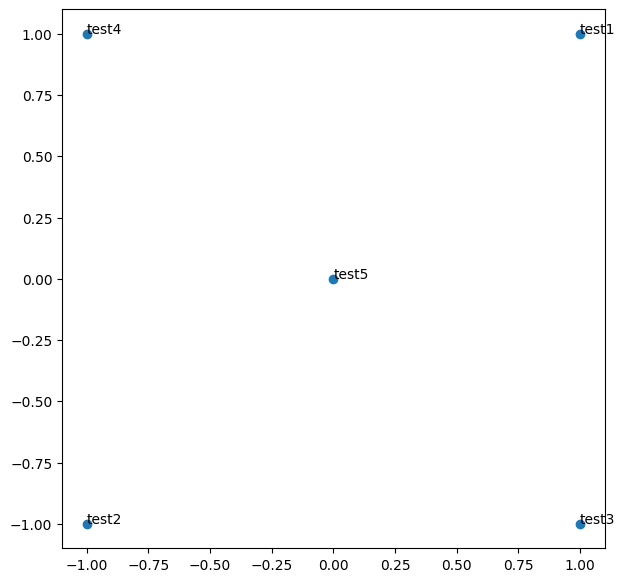

--------------------------------------------------------------------------------


In [148]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below.
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

<font color=red>**Test Plot Solution**</font>
<br>
<img src="./imgs/test_plot.png" width=40% style="float: left;"> </img>


### Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "crude" (oil) corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?  **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...


/Users/alirezanoroozi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/alirezanoroozi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/alirezanoroozi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/alirezanoroozi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/alirezanoroozi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/alirezanoroozi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value enc

Done.


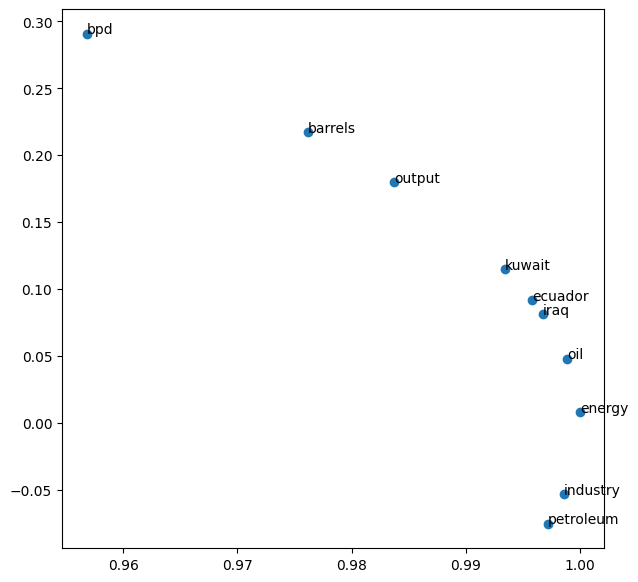

In [149]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

#### <font color="red">Write your answer here.</font>
The Countries are clustered but bpd and barrels are not

## Part 2: Prediction-Based Word Vectors (15 points)

As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [150]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    # print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin

In [151]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

#### Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download.

### Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead.
Run the following cells to:

1. Put 10000 Glove vectors into a matrix M
2. Run `reduce_to_k_dim` (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [152]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    # words = list(wv_from_bin.vocab.keys())
    words = list(wv_from_bin.key_to_index.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [153]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


/Users/alirezanoroozi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/alirezanoroozi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/alirezanoroozi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/alirezanoroozi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/alirezanoroozi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/alirezanoroozi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value enc

**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please go to office hours or contact course staff.**

### Question 2.1: GloVe Plot Analysis [written] (3 points)

Run the cell below to plot the 2D GloVe embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you think should have? How is the plot different from the one generated earlier from the co-occurrence matrix? What is a possible cause for the difference?

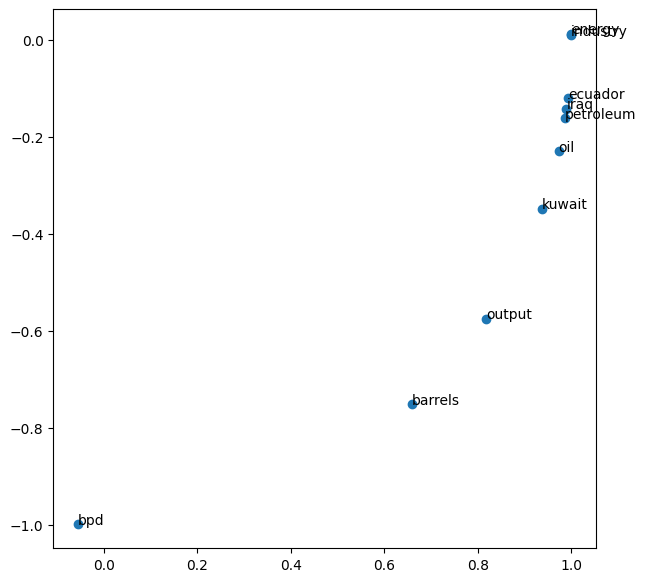

In [154]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_reduced_normalized, word2ind, words)

#### <font color="red">Write your answer here.</font>
energy and industry are very well clustered but kuwait is far from iraq and ecuador

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="./imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$

### Question 2.2: Words with Multiple Meanings (1.5 points) [code + written]
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). Find a word with *at least two different meanings* such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one.

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [267]:
# ------------------
# Write your implementation here.

word = "bear"
top_similar = wv_from_bin.most_similar(word, topn=10)

print(f"Top 10 most similar words to '{word}':")
for similar_word, similarity in top_similar:
    print(f"{similar_word}: {similarity:.4f}")


# ------------------

Top 10 most similar words to 'bear':
bears: 0.6849
grizzly: 0.6034
wolf: 0.5907
stearns: 0.5705
lion: 0.5358
bearing: 0.5107
dog: 0.5077
big: 0.4913
bore: 0.4898
deer: 0.4877


#### <font color="red">Write your answer here.</font>
This happens because the model mostly sees the common meaning of a word in the training data. So, its embedding reflects that frequent sense and doesn’t capture the rarer meanings well.

### Question 2.3: Synonyms & Antonyms (2 points) [code + written]

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words $(w_1,w_2,w_3)$ where $w_1$ and $w_2$ are synonyms and $w_1$ and $w_3$ are antonyms, but Cosine Distance $(w_1,w_3) <$ Cosine Distance $(w_1,w_2)$.

As an example, $w_1$="happy" is closer to $w_3$="sad" than to $w_2$="cheerful". Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [271]:
# ------------------
# Write your implementation here.
w1 = "happy"
antonym = "sad"
synonym = "cheerful"

def distance_between_words(w1, antonym, synonym):
    dist_antonym = wv_from_bin.distance(w1, antonym)
    dist_synonym = wv_from_bin.distance(w1, synonym)

    print(f"Cosine distance between '{w1}' and synonym '{synonym}': {dist_synonym:.4f}")
    print(f"Cosine distance between '{w1}' and antonym '{antonym}': {dist_antonym:.4f}")

    if dist_antonym < dist_synonym:
        print(f"'{w1}' is closer to antonym '{antonym}' than to synonym '{synonym}'.")
    else:
        print(f"'{w1}' is closer to synonym '{synonym}' than to antonym '{antonym}'.")

distance_between_words(w1, antonym, synonym)

w1 = "night"
antonym = "day"
synonym = "evening"

distance_between_words(w1, antonym, synonym)

# ------------------

Cosine distance between 'happy' and synonym 'cheerful': 0.5172
Cosine distance between 'happy' and antonym 'sad': 0.4040
'happy' is closer to antonym 'sad' than to synonym 'cheerful'.
Cosine distance between 'night' and synonym 'evening': 0.1985
Cosine distance between 'night' and antonym 'day': 0.2912
'night' is closer to synonym 'evening' than to antonym 'day'.


#### <font color="red">Write your answer here.</font>
"night" is closer to its synonym "evening" than to its antonym "day".
This makes sense because "night" and "evening" are more often used together or in similar ways.

### Question 2.4: Analogies with Word Vectors [written] (1.5 points)
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies.

As an example, for the analogy "man : king :: woman : x" (read: man is to king as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x using the `most_similar` function from the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar)__. The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://www.aclweb.org/anthology/N18-2039.pdf)). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [157]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6978679299354553),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998258590698),
 ('elizabeth', 0.5463595986366272),
 ('daughter', 0.5399126410484314),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164473056793213)]


Let $m$, $k$, $w$, and $x$ denote the word vectors for `man`, `king`, `woman`, and the answer, respectively. Using **only** vectors $m$, $k$, $w$, and the vector arithmetic operators $+$ and $-$ in your answer, what is the expression in which we are maximizing cosine similarity with $x$?

Hint: Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector. Where would `man` and `woman` lie in the coordinate plane relative to `king` and the answer?

#### <font color="red">Write your answer here.</font>
The answer is: x = w - m + k



### Question 2.5: Finding Analogies [code + written]  (1.5 points)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [ ]:
# ------------------
# Write your implementation here.

result = wv_from_bin.most_similar(positive=['berlin', 'france'], negative=['paris'])
pprint.pprint(result)


# ------------------

[('germany', 0.8352416753768921),
 ('german', 0.6844802498817444),
 ('austria', 0.6128034591674805),
 ('poland', 0.5813312530517578),
 ('germans', 0.5748683214187622),
 ('munich', 0.5435904264450073),
 ('belgium', 0.5324130058288574),
 ('britain', 0.5295413732528687),
 ('europe', 0.5244017839431763),
 ('czech', 0.5152410864830017)]


#### <font color="red">Write your answer here.</font>
in this example I find out that it can find the relation between countries and capitals

### Question 2.6: Incorrect Analogy [code + written] (1.5 points)
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [280]:
# ------------------
# Write your implementation here.

result = wv_from_bin.most_similar(positive=['restaurant', 'barbershop'], negative=['waiter'])
pprint.pprint(result)


# ------------------

[('restaurants', 0.4847806692123413),
 ('eatery', 0.4584985673427582),
 ('chinatown', 0.42634087800979614),
 ('chain', 0.4243856370449066),
 ('shops', 0.42361733317375183),
 ('cafe', 0.42094600200653076),
 ('neighborhood', 0.41790443658828735),
 ('eateries', 0.41750651597976685),
 ('bakery', 0.41671523451805115),
 ('shop', 0.4022028148174286)]


#### <font color="red">Write your answer here.</font>
It should find barber as the one who works there

### Question 2.7: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "worker" and most dissimilar to "man", and (b) which terms are most similar to "man" and "worker" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [160]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('employee', 0.6375863552093506),
 ('workers', 0.6068919897079468),
 ('nurse', 0.5837947130203247),
 ('pregnant', 0.5363885760307312),
 ('mother', 0.5321308970451355),
 ('employer', 0.5127025246620178),
 ('teacher', 0.5099577307701111),
 ('child', 0.5096741318702698),
 ('homemaker', 0.5019454956054688),
 ('nurses', 0.4970572590827942)]

[('workers', 0.611325740814209),
 ('employee', 0.5983108282089233),
 ('working', 0.5615329742431641),
 ('laborer', 0.5442320108413696),
 ('unemployed', 0.536851704120636),
 ('job', 0.5278826951980591),
 ('work', 0.5223963260650635),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.5054520964622498),
 ('factory', 0.4940454363822937)]


#### <font color="red">Write your answer here.</font>
It is very biased on that nurse and teachers are for women and labor and jobs are for men

### Question 2.8: Independent Analysis of Bias in Word Vectors [code + written]  (1 point)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [281]:
# ------------------
# Write your implementation here.

pprint.pprint(wv_from_bin.most_similar(positive=['criminal', 'black'], negative=['white']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['criminal', 'white'], negative=['black']))

# ------------------

[('crime', 0.6807922720909119),
 ('crimes', 0.6437058448791504),
 ('murder', 0.5849837064743042),
 ('criminals', 0.5628868341445923),
 ('defendants', 0.556655764579773),
 ('law', 0.5557766556739807),
 ('convicted', 0.549165666103363),
 ('charges', 0.538665771484375),
 ('prosecution', 0.5371394753456116),
 ('offenses', 0.5340662002563477)]

[('crimes', 0.6549562811851501),
 ('prosecution', 0.6519327759742737),
 ('charges', 0.610666036605835),
 ('investigations', 0.6090877056121826),
 ('investigation', 0.6073201298713684),
 ('indictment', 0.5964299440383911),
 ('prosecutors', 0.593210756778717),
 ('fbi', 0.5887480974197388),
 ('justice', 0.570600688457489),
 ('arrest', 0.5679643750190735)]


#### <font color="red">Write your answer here.</font>
It shows race-bias

### Question 2.9: Thinking About Bias [written] (2 points)

Give one explanation of how bias gets into the word vectors. What is an experiment that you could do to test for or to measure this source of bias?

#### <font color="red">Write your answer here.</font>
#### One explanation for how bias gets into word vectors is that the models are trained on large corpuses of texts. These texts reflect the patterns and contents in different fields, including those related to gender, race, occupation, and more. As the model learns word associations from these sources, biases are encoded in the resulting vector representations.

#### An experiment to test for or measure this source of bias is to use the "word embedding association test" (WEAT). In this test, you select two sets of target words (e.g., male and female terms) and two sets of attribute words (e.g., career-related and family-related words). By measuring the relative similarity between target and attribute sets in the embedding space, you can quantify to what extent, for example, male words are closer to career words compared to female words. The degree of association provides a way to measure bias present in the word vectors.



## Part 3: Sentiment Analysis (15 points)

Lastly, you will implement a simple sentiment classifier **from scratch** by using the Deep Averaging Network (DAN) proposed in the [paper](https://aclanthology.org/P15-1162.pdf). The model is based on the following three steps:

- Take the vector average of the embeddings associated with the words in the inputs
- Pass that average vector through one or more feed-forward layers
- Perform linear classification on the final layer’s representation


Here, you will use Stanford Sentiment Treebank (SST) dataset but note that in this dataset, the sentiment levels are originally represented with real values. Hence, you need to discretize these values into the following five classes:


- 0: "very negative" ($\le 0.2$),
- 1: "negative" ($\le 0.4$),
- 2: "neutral" ($\le 0.6$),
- 3: "positive" ($\le 0.8$),
- 4: "very positive" ($>$ 0.8)


### Download the Dataset
You can download the dataset [here](https://nlp.stanford.edu/sentiment/) (Download the "**Main zip file with readme (6mb)**" version). Please read `README.txt` in details, that comes with the .zip folder.

**Create a /data directory to store your SST data and unzip your downloaded folder there.** Your data path should be like following:

```
./comp541-441/assignment1/data
                            └── stanfordSentimentTreebank
                                ├── README.txt
                                ├── SOStr.txt
                                ├── STree.txt
                                ├── datasetSentences.txt
                                ├── datasetSplit.txt
                                ├── dictionary.txt
                                ├── original_rt_snippets.txt
                                └── sentiment_labels.txt
```

Or, you can simply use Huggingface's **datasets** library if you are familiar.

### What to show
In your work, perform the following experiments and explain your findings:

- Provide your loss curves by plotting them clearly,
- Play with the number of layers,
- Try with embeddings trained on different corpuses
- Test with the GloVe embeddings and the embeddings formed through the word co-occurrence matrix. Report your results on the test set for both types of embeddings (make sure to use the same test set for both, to ensure a fair comparison).

In [ ]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from collections import Counter


### Dataset & DataLoader

In [197]:
data_dir = "./data/stanfordSentimentTreebank"  # Update if your data location is different

# Load sentences (sentence index→sentence string)
sent_file = os.path.join(data_dir, 'datasetSentences.txt')
sents_df = pd.read_csv(sent_file, sep='\t')
print(len(sents_df), "number of sentences")
idx2sent = dict(zip(sents_df['sentence_index'], sents_df['sentence']))

# Load phrase→phrase id
dict_file = os.path.join(data_dir, 'dictionary.txt')
phrase2id = {}
with open(dict_file, encoding="utf-8") as f:
    for line in f:
        phrase, id_ = line.strip().split('|')
        phrase2id[phrase] = int(id_)
id2phrase = {v: k for k, v in phrase2id.items()}

# Load phrase id→sentiment value
label_file = os.path.join(data_dir, 'sentiment_labels.txt')
labels_df = pd.read_csv(label_file, sep='|')
print(len(labels_df), "number of phrase-level labels")
id2label = dict(zip(labels_df['phrase ids'].astype(str), labels_df['sentiment values']))

# Load split info
split_file = os.path.join(data_dir, 'datasetSplit.txt')
split_df = pd.read_csv(split_file)
print(len(split_df), "number of splits")
idx2split = dict(zip(split_df['sentence_index'], split_df['splitset_label']))

sostree_file = os.path.join(data_dir, 'SOStr.txt')
with open(sostree_file, encoding="utf-8") as f:
    sostree = f.readlines()
print(len(sostree), "number of sostree")

11855 number of sentences
239232 number of phrase-level labels
11855 number of splits
11855 number of sostree


In [215]:
def discretize_sentiment(y):
    """Discretize sentiment value to 0-4 class."""
    y = float(y)
    if y <= 0.2:
        return 0
    elif y <= 0.4:
        return 1
    elif y <= 0.6:
        return 2
    elif y <= 0.8:
        return 3
    else:
        return 4

def load_sst_data():
    splits = {1: [], 2: [], 3: []}  # 1=train, 2=test, 3=dev
    for idx in sents_df['sentence_index']:
        sent = idx2sent[idx]                           # get sentence string
        sentiment = id2label.get(str(idx))

        y = discretize_sentiment(sentiment)
        split = idx2split[idx]
        splits[split].append((sent, sostree[idx - 1].split("|"), y))
    return splits

def get_glove_matrix(word2idx):
    emb_dim = 200
    emb_matrix = np.zeros((len(word2idx), emb_dim), dtype=np.float32)
    for w, i in word2idx.items():
        try:
            emb_matrix[i] = wv_from_bin[w]
        except KeyError:
            if w in ['<pad>', '<unk>', '<bos>', '<eos>']:
                emb_matrix[i] = np.zeros(emb_dim)
    glove_dict = {i: emb_matrix[i] for i in range(len(word2idx))}
    return glove_dict


In [226]:
class SSTDataset(Dataset):
    def __init__(self, data, word2idx, max_len=64):
        self.data = data
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence, words, label = self.data[idx]
        idxs = [self.word2idx['<bos>']] + [self.word2idx.get(w.lower(), self.word2idx['<unk>']) for w in words] + [self.word2idx['<eos>']]
        # Pad or truncate
        if len(idxs) < self.max_len:
            idxs += [self.word2idx['<pad>']] * (self.max_len - len(idxs))
        else:
            idxs = idxs[:self.max_len]
        mask = (torch.tensor(idxs) != self.word2idx['<pad>']).float()
        return torch.tensor(idxs, dtype=torch.long), label, sentence, mask
    
class GloveDataset(Dataset):
    def __init__(self, data, glove_matrix, max_len=64):
        self.data = data
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence, words, label = self.data[idx]
        idxs = []
        for w in words:
            try:
                idxs.append(wv_from_bin[w])
            except KeyError:
                idxs.append(np.zeros(200))
            
        if len(idxs) < self.max_len:
            idxs += [np.zeros(200)] * (self.max_len - len(idxs))
        else:
            idxs = idxs[:self.max_len]
        mask = torch.zeros(self.max_len, dtype=torch.float32)
        mask[:min(len(words), self.max_len)] = 1.0
        return torch.tensor(idxs, dtype=torch.float32), label, sentence, mask

Loading data
8544 number of train data
2210 number of test data
1101 number of dev data
Train sentence max length: 52
Dev sentence max length: 49
Test sentence max length: 56
Counter({2: 4582, 1: 1551, 3: 1499, 4: 464, 0: 448})
Counter({2: 1155, 3: 424, 1: 405, 0: 114, 4: 112})
Counter({2: 503, 1: 219, 3: 216, 4: 87, 0: 76})


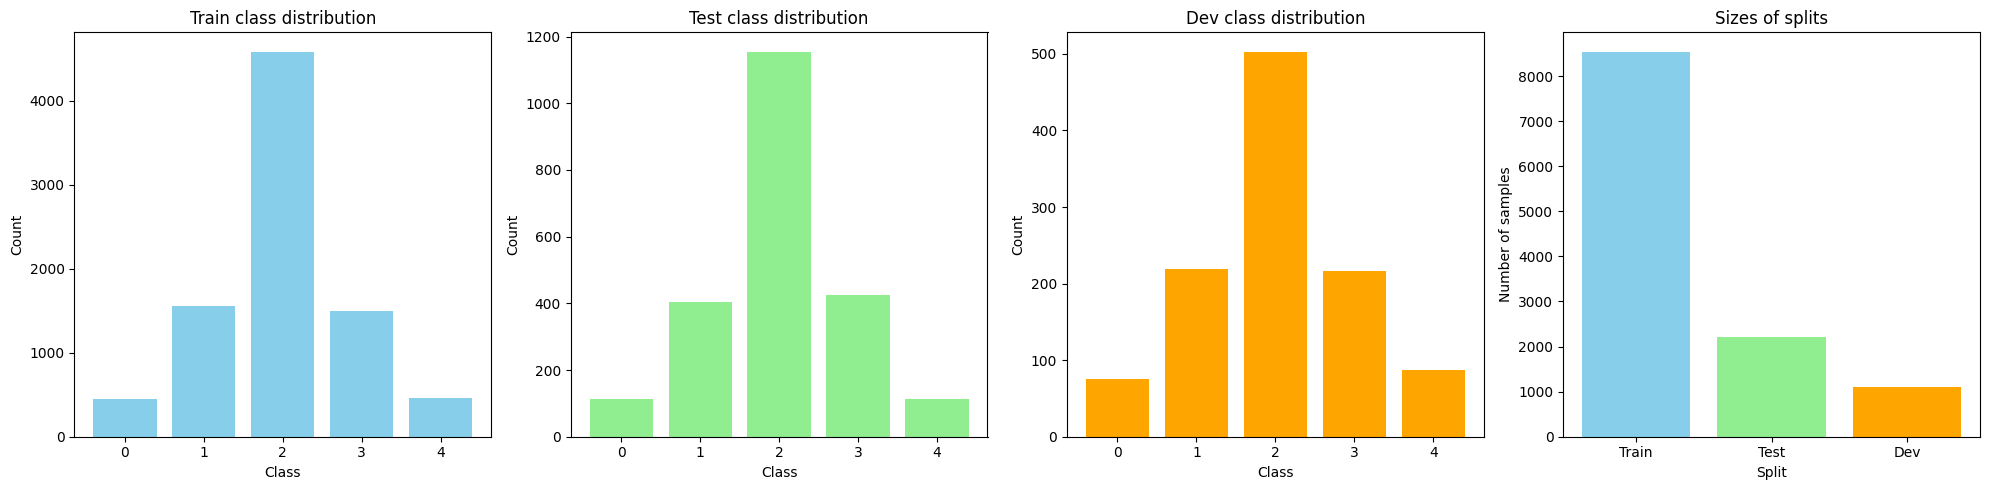

In [227]:
print("Loading data")
splits = load_sst_data()
train_data = splits[1]
test_data = splits[2]
dev_data = splits[3]

print(len(train_data), "number of train data")
print(len(test_data), "number of test data")
print(len(dev_data), "number of dev data")

# Compute label distributions
all_classes_train = [x[2] for x in train_data]
all_classes_test = [x[2] for x in test_data]
all_classes_dev = [x[2] for x in dev_data]

train_sentece_lenmax = max([len(x[1]) for x in train_data])
dev_sentece_lenmax = max([len(x[1]) for x in dev_data])
test_sentece_lenmax = max([len(x[1]) for x in test_data])

print(f"Train sentence max length: {train_sentece_lenmax}")
print(f"Dev sentence max length: {dev_sentece_lenmax}")
print(f"Test sentence max length: {test_sentece_lenmax}")   

train_counter = Counter(all_classes_train)
test_counter = Counter(all_classes_test)
dev_counter = Counter(all_classes_dev)
sizes = {"Train": len(train_data), "Test": len(test_data), "Dev": len(dev_data)}

print(train_counter)
print(test_counter)
print(dev_counter)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

# Plot 1: Distribution of classes in train
axs[0].bar(train_counter.keys(), train_counter.values(), color='skyblue')
axs[0].set_title("Train class distribution")
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Count")

# Plot 2: Distribution of classes in test
axs[1].bar(test_counter.keys(), test_counter.values(), color='lightgreen')
axs[1].set_title("Test class distribution")
axs[1].set_xlabel("Class")
axs[1].set_ylabel("Count")

# Plot 3: Distribution of classes in dev
axs[2].bar(dev_counter.keys(), dev_counter.values(), color='orange')
axs[2].set_title("Dev class distribution")
axs[2].set_xlabel("Class")
axs[2].set_ylabel("Count")

# Plot 4: Data size in each split
splits_names = list(sizes.keys())
split_sizes = list(sizes.values())
axs[3].bar(splits_names, split_sizes, color=['skyblue','lightgreen','orange'])
axs[3].set_title("Sizes of splits")
axs[3].set_xlabel("Split")
axs[3].set_ylabel("Number of samples")

plt.tight_layout()
plt.show()

word2idx = {'<pad>': 0, '<unk>': 1, '<bos>': 2, '<eos>': 3}
word2idx.update({phrase2id: i for i, phrase2id in enumerate(phrase2id, start=4)})
glove_matrix = get_glove_matrix(word2idx)

train_dataset = SSTDataset(train_data, word2idx)
test_dataset = SSTDataset(test_data, word2idx)
dev_dataset = SSTDataset(dev_data, word2idx)

glove_train_dataset = GloveDataset(train_data, word2idx)
glove_test_dataset = GloveDataset(test_data, word2idx)
glove_dev_dataset = GloveDataset(dev_data, word2idx)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

glove_train_loader = DataLoader(glove_train_dataset, batch_size=batch_size, shuffle=True)
glove_dev_loader = DataLoader(glove_dev_dataset, batch_size=batch_size)
glove_test_loader = DataLoader(glove_test_dataset, batch_size=batch_size)


### DAN Model

In [253]:
class DAN(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dims, n_classes, use_pretrained=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.use_pretrained = use_pretrained
        if use_pretrained:
            emb_dim = 200
        layers = []
        last_dim = emb_dim
        for h in hidden_dims:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.ReLU())
            last_dim = h
        self.mlp = nn.Sequential(*layers)
        self.final = nn.Linear(last_dim, n_classes)

    def forward(self, x, mask=None):
        """
        x: (batch, seq)
        """
        if not self.use_pretrained:
            emb = self.embedding(x)  # (batch, seq, emb_dim)
            mask = (x != 0).unsqueeze(-1)  # (batch, seq, 1)

        else:
            emb = x
            mask = mask.unsqueeze(-1)
            
        sum_emb = (emb * mask).sum(dim=1)
        lens = mask.sum(dim=1).clamp(min=1)
        avg = sum_emb / lens  # (batch, emb_dim)
        x = self.mlp(avg)
        out = self.final(x)
        return out

### Training Loop

In [258]:
def train_model(model, train_loader, dev_loader, n_epochs=3, lr=1e-3):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    dev_losses = []
    best_dev = None
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        for x, y, s, mask in train_loader:
            optimizer.zero_grad()
            logits = model(x, mask)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()*x.size(0)
        epoch_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        # Evaluate on dev
        model.eval()
        dev_loss = 0
        correct = 0
        with torch.no_grad():
            for x, y, s, mask in dev_loader:
                logits = model(x, mask)
                loss = loss_fn(logits, y)
                dev_loss += loss.item()*x.size(0)
                preds = torch.argmax(logits, 1)
                correct += (preds == y).sum().item()
        dev_loss = dev_loss / len(dev_loader.dataset)
        dev_losses.append(dev_loss)
        dev_acc = correct / len(dev_loader.dataset)
        print(f"Epoch {epoch+1} | Train Loss: {epoch_loss:.4f} | Dev Loss: {dev_loss:.4f} | Dev Acc: {dev_acc:.3f}")
        
        if best_dev is None or dev_acc > best_dev:
            best_dev = dev_acc
            best_state = model.state_dict()

    model.load_state_dict(best_state)
    return train_losses, dev_losses

def test_model(model, test_loader):
    model.eval()
    correct = 0
    
    with torch.no_grad():
        for i, (x, y, s, mask) in enumerate(test_loader):
            logits = model(x, mask)
            preds = torch.argmax(logits, 1)
            correct += (preds == y).sum().item()
            if i == 1:
                for j, sent, label, pred in zip(range(10), s[:10], y[:10], preds[:10]):
                    print(f"Sample {j+1}: Sentence: {sent}, Label: {label}, Pred: {pred}")
    test_acc = correct / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.3f}")
    return test_acc

Building model
Number of parameters: 47899941
Training
Epoch 1 | Train Loss: 1.2878 | Dev Loss: 1.4150 | Dev Acc: 0.457
Epoch 2 | Train Loss: 1.2463 | Dev Loss: 1.4357 | Dev Acc: 0.457
Epoch 3 | Train Loss: 1.1726 | Dev Loss: 1.4688 | Dev Acc: 0.416
Epoch 4 | Train Loss: 1.0084 | Dev Loss: 1.5965 | Dev Acc: 0.374
Epoch 5 | Train Loss: 0.7845 | Dev Loss: 1.8773 | Dev Acc: 0.375
Epoch 6 | Train Loss: 0.5578 | Dev Loss: 2.1928 | Dev Acc: 0.345
Epoch 7 | Train Loss: 0.3716 | Dev Loss: 2.5405 | Dev Acc: 0.340
Epoch 8 | Train Loss: 0.2308 | Dev Loss: 2.9858 | Dev Acc: 0.350
Epoch 9 | Train Loss: 0.1366 | Dev Loss: 3.4453 | Dev Acc: 0.337
Epoch 10 | Train Loss: 0.0801 | Dev Loss: 3.8875 | Dev Acc: 0.343
Evaluating on test set
Sample 1: Sentence: A masterpiece four years in the making ., Label: 3, Pred: 2
Sample 2: Sentence: The movie 's ripe , enrapturing beauty will tempt those willing to probe its inscrutable mysteries ., Label: 2, Pred: 3
Sample 3: Sentence: Offers a breath of the fresh ai

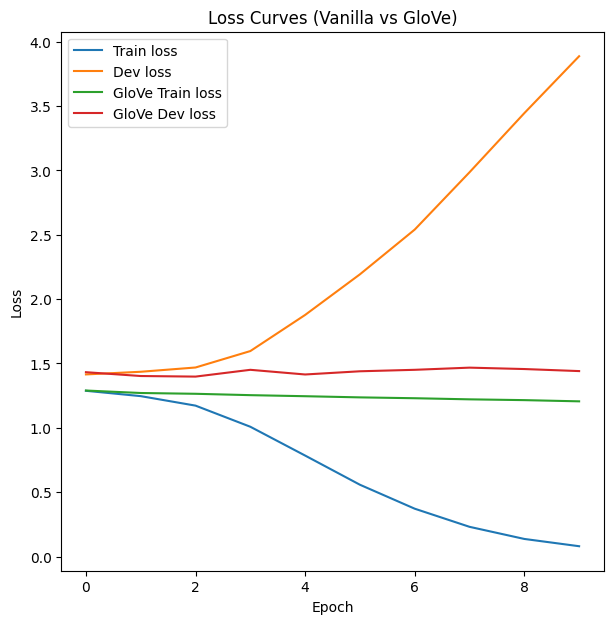

In [283]:
# ------------------
# Start your implementation here.
emb_dim = 200
hidden_dims = [256]

print("Building model")
model = DAN(len(word2idx), emb_dim, hidden_dims, n_classes=5)
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

glove_model = DAN(len(word2idx), emb_dim, hidden_dims, n_classes=5, use_pretrained=True)
glove_num_params = sum(p.numel() for p in glove_model.parameters())

print("Training")
train_losses, dev_losses = train_model(model, train_loader, dev_loader, n_epochs=10)

print("Evaluating on test set")
test_acc = test_model(model, test_loader)

print("--------------------------------")

print("Training Glove Model")
glove_train_losses, glove_dev_losses = train_model(glove_model, glove_train_loader, glove_dev_loader, n_epochs=10, lr=1e-2)

print("Evaluating on test set")
glove_test_acc = test_model(glove_model, glove_test_loader)

# Plotting loss curves
plt.figure(figsize=(7,7))
plt.plot(train_losses, label="Train loss")
plt.plot(dev_losses, label="Dev loss")
plt.plot(glove_train_losses, label="GloVe Train loss")
plt.plot(glove_dev_losses, label="GloVe Dev loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves (Vanilla vs GloVe)")
plt.show()

# ------------------

Building model
Number of parameters: 47932197
Training
Epoch 1 | Train Loss: 1.2852 | Dev Loss: 1.3963 | Dev Acc: 0.457
Epoch 2 | Train Loss: 1.2513 | Dev Loss: 1.4184 | Dev Acc: 0.457
Epoch 3 | Train Loss: 1.1912 | Dev Loss: 1.4950 | Dev Acc: 0.458
Epoch 4 | Train Loss: 1.0230 | Dev Loss: 1.6294 | Dev Acc: 0.384
Epoch 5 | Train Loss: 0.7590 | Dev Loss: 2.1118 | Dev Acc: 0.398
Epoch 6 | Train Loss: 0.4695 | Dev Loss: 2.7147 | Dev Acc: 0.344
Epoch 7 | Train Loss: 0.2289 | Dev Loss: 3.7827 | Dev Acc: 0.354
Epoch 8 | Train Loss: 0.1021 | Dev Loss: 4.9127 | Dev Acc: 0.360
Epoch 9 | Train Loss: 0.0451 | Dev Loss: 5.5296 | Dev Acc: 0.338
Epoch 10 | Train Loss: 0.0253 | Dev Loss: 5.9064 | Dev Acc: 0.329
Evaluating on test set
Sample 1: Sentence: A masterpiece four years in the making ., Label: 3, Pred: 2
Sample 2: Sentence: The movie 's ripe , enrapturing beauty will tempt those willing to probe its inscrutable mysteries ., Label: 2, Pred: 3
Sample 3: Sentence: Offers a breath of the fresh ai

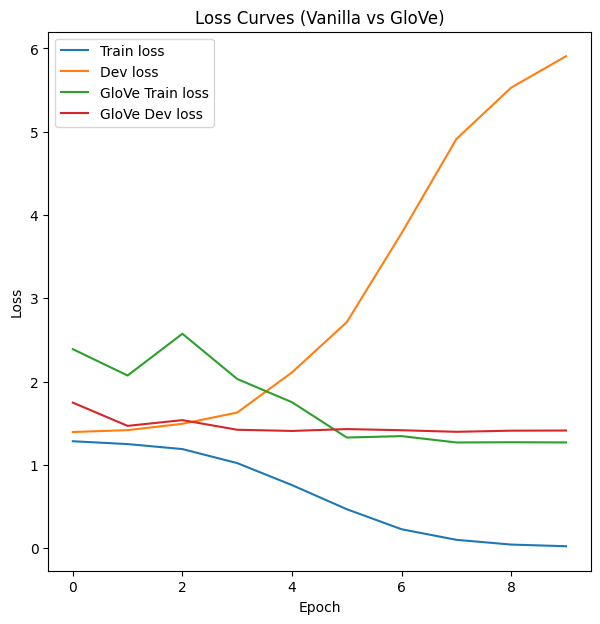

In [284]:
# ------------------
# Start your implementation here.
emb_dim = 200
hidden_dims = [256, 128]

print("Building model")
model = DAN(len(word2idx), emb_dim, hidden_dims, n_classes=5)
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

glove_model = DAN(len(word2idx), emb_dim, hidden_dims, n_classes=5, use_pretrained=True)
glove_num_params = sum(p.numel() for p in glove_model.parameters())

print("Training")
train_losses, dev_losses = train_model(model, train_loader, dev_loader, n_epochs=10)

print("Evaluating on test set")
test_acc = test_model(model, test_loader)

print("--------------------------------")

print("Training Glove Model")
glove_train_losses, glove_dev_losses = train_model(glove_model, glove_train_loader, glove_dev_loader, n_epochs=10, lr=1e-1)

print("Evaluating on test set")
glove_test_acc = test_model(glove_model, glove_test_loader)

# Plotting loss curves
plt.figure(figsize=(7,7))
plt.plot(train_losses, label="Train loss")
plt.plot(dev_losses, label="Dev loss")
plt.plot(glove_train_losses, label="GloVe Train loss")
plt.plot(glove_dev_losses, label="GloVe Dev loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves (Vanilla vs GloVe)")
plt.show()

# ------------------

# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of all cells).
3. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
4. You have two options for the submission. You need to either submit your final .ipynb notebook, or its "pdf" version. Note that in all cases, we expect you to put everything that we asked for (codes, outputs, written answers, visual results etc.) in that single file.
5. A: If you choose to submit a pdf, once you've rerun everything, select File -> Download as -> PDF via LaTeX (If you have trouble using "PDF via LaTex", you can also save the webpage as pdf. Make sure all your solutions especially the coding parts are displayed in the pdf, it's okay if the provided codes get cut off and go into the next page because lines are not wrapped in code cells). Look at the PDF file and make sure all your solutions are there, displayed correctly. NOTE: If you have any problems with this way of extracting and downloading the PDF, you are free to use ANY tool to make it work, as long as you are able to provide a usual PDF with all the requirements formatted nicely in it.
5. B: If you choose to submit the notebook itself, download a .ipynb version of your notebook while making sure that its all-comprehensive and self-contained.
6. Please name your files as username_assignment1.ipynb or username_assignment1.pdf.
7. Submit your work to Learnhub by the deadline.

*This assignment is adapted from Stanford [CS224n](http://web.stanford.edu/class/cs224n/)*